# Text Mining Project

### NOVA IMS MT Metrics Shared Task

**Group members:**
- Lorenzo Pigozzi	--- m20200745
- Davide Farinati
- Antonio
- Luis Reis

**Objective**

The goal of this project is to develop a metric that predicts the quality of a translation using the reference. 

\
**Evaluation**\
Your metric should correlate well with the existing quality assessments that you have in the above corpus.
The one that we have so far are just the training sets, we will have a test set without the z-score, average score and annotators.
Produce our own metric that will be compared with the existing ones.


<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Importing libraries and corpora](#1)   
2.	[Brief Exploratory data analysis (EDA)](#2)       
3.	[Pre-processing](#3.)     
 3.1. [Cleaning](#3.1.)\
 3.2. [Train-dev-test](#3.2.)
4. [Metrics](#4.)
5. [Modeling](#5.)

**Notes**\
Sklearn:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## 1. Importing libraries and corpora <a class="anchor" id="1"></a>

In [1]:
# general libraries
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# word's preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from nltk.translate.bleu_score import sentence_bleu
from bs4 import BeautifulSoup
import string

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing the corpora
cs_en = pd.read_csv('corpus\cs-en\scores.csv')
de_en = pd.read_csv('corpus\de-en\scores.csv')
ru_en = pd.read_csv('corpus\scores_ru-en.csv')
zh_en = pd.read_csv('corpus\zh-en\scores.csv')
en_fi = pd.read_csv('corpus\en-fi\scores.csv')
en_zh = pd.read_csv('corpus\en-zh\scores.csv')

## 2. Brief Exploratory Data Analysis <a class="anchor" id="2"></a>

In [3]:
en_fi.head()

source  \
0  You can turn yourself into a pineapple, a dog ...   
1  Also shot were three men: two 29-year-olds and...   
2  The information is stored at the cash register...   
3  Xinhua says that there were traces of hydrochl...   
4  MacDonald, who was brought on board CBC's comm...   

                                           reference  \
0  Voit muuttaa itsesi ananasta, koirasta tai Roy...   
1  Myös ammuttiin kolme miestä: kaksi 29-vuotiait...   
2  Tiedot tallennetaan kassakoneisiin joka tapauk...   
3  Xinhua kertoo, että Xinyin näytteestä oli sunn...   
4  Voitaisiin kuulla CBD: n kommenttitiimin toimi...   

                                         translation   z-score  avg-score  \
0  Voit muuttaa itsesi ananakseksi, koiraksi tai ... -0.286195      34.20   
1  Myös kolmea miestä ammuttiin: kahta 29-vuotias...  0.547076      58.40   
2  Tiedot kuitenkin tallentuvat kassoilla joka ta...  1.122476      74.60   
3  Xinhua kertoo, että Xinyin sunnuntaina antamas...  0.383095      53.60   
4  MacDonaldin, joka tuli CBC:n selostajatiimiin ... -0.493065      32.25   

   annotators  
0           5  
1           5  
2           5  
3           5  
4           4

**Notes**\
All the the Dataframes imported have 6 columns:
- Sources: the original text in the original language
- Reference: The correct translation
- Translation: the translation that we will evaluate
- Z-score: score of the translation normalized
- Avg-score: score of the translation from 0 to 100
- Annotators: number of annotators

In [4]:
print('Total number of translations : ',len(cs_en) + len(de_en) + len(ru_en) + len(zh_en) + len(en_fi) + len(en_zh) )

Total number of translations :  94657


**Idea**\
Splitting the problem in 3:
- estimate the translations from other languages to English
- estimate the translations from English to Finnish
- estimate the translations from English to Chinese

\
Reason:\
Proably going forward we will need to have different preprocessing for English and for the other 2 languages

#  3. Pre-processing <a class="anchor" id="3."></a>

In [5]:
cs_en.head()

source  \
0  Uchopíte pak zbraň mezi své předloktí a rameno...   
1  Ale je-li New York změna, pak je to také znovu...   
2  Dlouho a intenzivně jsem během léta přemýšlel,...   
3         Najdou si jiný způsob, jak někde podvádět.   
4  Zpráva o výměně v čele prezidentovy administra...   

                                           reference  \
0  You will then grab the weapon between your for...   
1  But if New York is changed, then it's also a r...   
2  I have been thinking over and over again over ...   
3          They find another way to cheat somewhere.   
4  The report on the replacement of the president...   

                                         translation   z-score  avg-score  \
0  You then grasp the gun between your forearm an... -0.675383  60.000000   
1  But if New York is change, it is also reinvent... -0.829403  44.000000   
2  I have thought long and hard over the course o...  0.803185  96.500000   
3  They will find another way how to defraud others.  0.563149  90.500000   
4  The news of the replacement at the top of the ...  0.021549  74.666667   

   annotators  
0           3  
1           2  
2           2  
3           2  
4           3

In [6]:
# selecting the necessary variables for the baseline
cs_en = cs_en[['reference','translation','avg-score']]
de_en = de_en[['reference','translation','avg-score']]
ru_en = ru_en[['reference','translation','avg-score']]
zh_en = zh_en[['reference','translation','avg-score']]

In [7]:
cs_en.head()

reference  \
0  You will then grab the weapon between your for...   
1  But if New York is changed, then it's also a r...   
2  I have been thinking over and over again over ...   
3          They find another way to cheat somewhere.   
4  The report on the replacement of the president...   

                                         translation  avg-score  
0  You then grasp the gun between your forearm an...  60.000000  
1  But if New York is change, it is also reinvent...  44.000000  
2  I have thought long and hard over the course o...  96.500000  
3  They will find another way how to defraud others.  90.500000  
4  The news of the replacement at the top of the ...  74.666667

In [45]:
# joining the 4 datasets with English translations
english_corpus = pd.concat([cs_en, de_en, ru_en, zh_en], axis = 0).reset_index(drop=True)

## 3.1. Cleaning <a class="anchor" id="3.1."></a>

In [46]:
def clean(text_list,
          lower = False,
          keep_numbers = False,
          keep_expression = False,
          remove_char = False,
          remove_stop = False,
          remove_tag = False,
          lemmatize = False,
          stemmer = False,
          english = True
          ):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    if english:
        lang = 'english'
    else:
        lang = 'finnish'
    
    stop = set(stopwords.words(lang))
    stem = SnowballStemmer(lang)
    
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        if lower:
            text = text.lower()
            
        #KEEP NUMBERS AS TOKENS
        if keep_numbers:
            text = re.sub("[\d+]", 'NUMBER', text)
        
        #KEEP '?' and '!' AS TOKENS
        if keep_expression:
            text = re.sub("[\?|\!]", 'EXPRESSION', text)
            
        #REMOVE THAT IS NOT TEXT
        if remove_char:
            text = re.sub("[^a-zA-Z]", ' ', text)
            
        #REMOVE TAGS
        if remove_tag:
            text = BeautifulSoup(text).get_text()
        
        #REMOVE STOP WORDS
        if remove_stop:
            text = ' '.join([word for word in text.split(' ') if word not in stop])
        
        #LEMMATIZATION
        if lemmatize:
            if english:
                lemma = WordNetLemmatizer()
                text = " ".join(lemma.lemmatize(word) for word in text.split())
#             else:
#                 lemma = libvoikko.Voikko(u"fi")
#                 text = " ".join(lemma.analyze(word)[0]['BASEFORM'] for word in text.split())
        
        #STEMMER
        if stemmer:
            text = " ".join(stem.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def clean_zh_stopwords(text_list, stopwords_set='merged'):
    """
    Function that removes chinese stopwords
    
    :param stopwords_set: remove words of both sets (merged), just the 1st (fst) or just the second (snd) 
    """
    updates = []
    
    zh_stopwords1 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords1.txt', 'r', encoding='utf-8').readlines()]
    zh_stopwords2 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords2.txt', 'r', encoding='utf-8').readlines()]
    
    if stopwords_set == 'merged':
        stop = list(set(zh_stopwords1 + zh_stopwords2))
    elif stopwords_set == 'fst':
        stop = zh_stopwords1
    elif stopwords_set == 'snd':
        stop = zh_stopwords2
        

    for j in tqdm(range(len(text_list))):
        text = text_list[j]
        text = ' '.join([word for word in text.split(' ') if word not in stop])
        updates.append(text)
        
    return updates
        
    
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"Text": list_updated}))

In [47]:
english_cleaned = pd.DataFrame()
english_cleaned['avg-score'] = english_corpus['avg-score']
for column in ['reference', 'translation']:
    english_cleaned[column] = clean(english_corpus[column], lower = True, 
                                                    remove_char = True,
                                                    remove_stop = True,
                                                    lemmatize = True,
                                                    stemmer = False)

In [48]:
english_cleaned.head()

avg-score                                          reference  \
0  60.000000   grab weapon forearm shoulder hit face free elbow   
1  44.000000                  new york changed also rediscovery   
2  96.500000  thinking summer improve give depth need get hi...   
3  90.500000                   find another way cheat somewhere   
4  74.666667  report replacement president administration he...   

                                         translation  
0  grasp gun forearm shoulder hitting face free e...  
1                   new york change also reinvention  
2  thought long hard course summer might improve ...  
3                    find another way defraud others  
4  news replacement top president office come sur...

### 3.2. Train, Development and Test sets <a class="anchor" id="3.2."></a>

In [13]:
## train-dev-test split
train, test = train_test_split(english_cleaned, test_size=0.2, shuffle = True, random_state = 7)
test, dev = train_test_split(test, test_size=0.5, shuffle = True, random_state = 7)

# 4. Metrics <a class="anchor" id="4."></a>

### BLEU
**How to evauate a translation: BLEU**\
One thing you might do is look at each word in the output sentence and assign it a score of 1 if it shows up in any of the reference sentences and 0 if it doesn’t. Then, to normalize that count so that it’s always between 0 and 1, you can divide the number of words that showed up in one of the reference translations by the total number of words in the output sentence. This gives us a measure called unigram precision.\
https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

\
**A Gentle Introduction to Calculating the BLEU Score for Text in Python**
https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

\
**NLP Metrics Made Simple: The BLEU Score**\
https://towardsdatascience.com/nlp-metrics-made-simple-the-bleu-score-b06b14fbdbc1


\
"A popular metric is BLEU, which counts the sequences of words in the candidate that also appear in the reference (the BLEU score is very similar to precision)."\
https://ai.googleblog.com/2020/05/evaluating-natural-language-generation.html#:~:text=BLEURT%20is%20a%20novel,%20machine,ratings%20provided%20by%20the%20user.

In [15]:
## Example
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


In [16]:
# cumulative BLEU score
def avg_bleu_score(df, ngram = 'unigram'):
    bleu_scores = []
    for i in df.index:
        reference = []
        reference.append(df['reference'][i].split(' '))
        translation = df['translation'][i].split(' ')
        if ngram == 'bigram':
            bleu_scores.append(sentence_bleu(reference, translation, weights=(0.5, 0.5, 0, 0)))
        elif ngram == '3-gram':
            bleu_scores.append(sentence_bleu(reference, translation, weights=(0.33, 0.33, 0.33, 0)))
        elif ngram == '4-gram':
            bleu_scores.append(sentence_bleu(reference, translation, weights=(0.25, 0.25, 0.25, 0.25)))
        else:
            bleu_scores.append(sentence_bleu(reference, translation))
    return pd.Series(bleu_scores).mean(), bleu_scores

In [17]:
# calculating the scores
bleu_score_unigram, unigram_scores = avg_bleu_score(train)
bleu_score_bigram, bigram_scores = avg_bleu_score(train, ngram = 'bigram')
bleu_score_3gram, trigram_scores = avg_bleu_score(train, ngram = '3-gram')
bleu_score_4gram, fourgram_scores = avg_bleu_score(train, ngram = '4-gram')

In [18]:
grams = ['unigram', 'bigram', '3-gram', '4-gram']
bleu_scores = [bleu_score_unigram, bleu_score_bigram, bleu_score_3gram, bleu_score_4gram]
for i in range(len(grams)):
    print('Average BLEU score for', grams[i] ,' :', bleu_scores[i])

Average BLEU score for unigram  : 0.2076622654785226
Average BLEU score for bigram  : 0.4090547842910233
Average BLEU score for 3-gram  : 0.297260902239954
Average BLEU score for 4-gram  : 0.2076622654785226


In [19]:
# checking the correlation with the avg-score
bleu_score_relation = pd.concat([train.reset_index(drop=True), pd.Series(unigram_scores)], axis = 1).iloc[:, -2:]
pearson_unigram = bleu_score_relation.corr(method='pearson').iloc[1:2,:1].values[0][0]
bleu_score_relation = pd.concat([train.reset_index(drop=True), pd.Series(bigram_scores)], axis = 1).iloc[:, -2:]
pearson_bigram = bleu_score_relation.corr(method='pearson').iloc[1:2,:1].values[0][0]
bleu_score_relation = pd.concat([train.reset_index(drop=True), pd.Series(trigram_scores)], axis = 1).iloc[:, -2:]
pearson_3gram = bleu_score_relation.corr(method='pearson').iloc[1:2,:1].values[0][0]
bleu_score_relation = pd.concat([train.reset_index(drop=True), pd.Series(fourgram_scores)], axis = 1).iloc[:, -2:]
pearson_4gram = bleu_score_relation.corr(method='pearson').iloc[1:2,:1].values[0][0]

In [20]:
pearson_grams = [pearson_unigram, pearson_bigram, pearson_3gram, pearson_4gram]
for i in range(len(grams)):
    print('Pearson relations among Bleu and score', grams[i] ,' :', pearson_grams[i])

Pearson relations among Bleu and score unigram  : 0.2556770746721379
Pearson relations among Bleu and score bigram  : 0.3120262696218851
Pearson relations among Bleu and score 3-gram  : 0.2856859598242893
Pearson relations among Bleu and score 4-gram  : 0.2556770746721379


### ROUGE



**The Ultimate Performance Metric in NLP**\
https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460
http://www.ccs.neu.edu/home/vip/teach/DMcourse/5_topicmodel_summ/notes_slides/What-is-ROUGE.pdf

**How to evauate a translation: Rouge**

ROUGE-N measures the number of matching ‘n-grams’ between our model-generated text and a ‘reference’. Once we have decided which N to use — we now decide on whether we’d like to calculate the ROUGE recall, precision, or F1 score.\
ROUGE-L measures the longest common subsequence (LCS) between our model output and reference. All this means is that we count the longest sequence of tokens that is shared between both

In [21]:
# !pip install rouge
from rouge import Rouge

 #### Example:

In [22]:
model_out = "he began by starting a five person war cabinet and included chamberlain as lord president of the council"
reference = "he began his premiership by forming a five-man war cabinet which included chamberlain as lord president of the council"
rouge = Rouge()

**How to evauate a translation: Rouge**\
The get_scores method returns three metrics, ROUGE-N using a unigram (ROUGE-1) and a bigram (ROUGE-2) — and ROUGE-L.
For each of these, we receive the F1 score f, precision p, and recall r.

In [23]:
scores=rouge.get_scores(model_out, reference)
print(scores)

[{'rouge-1': {'f': 0.7567567517604091, 'p': 0.7777777777777778, 'r': 0.7368421052631579}, 'rouge-2': {'f': 0.514285709289796, 'p': 0.5294117647058824, 'r': 0.5}, 'rouge-l': {'f': 0.7567567517604091, 'p': 0.7777777777777778, 'r': 0.7368421052631579}}]


#### Real:

In [24]:
references =df['reference'].to_list()
translation =df['translation'].to_list()

In [25]:
print(len(references))
print(len(translation))

77688
77688


In [26]:
scores = rouge.get_scores(references, translation, avg=True,ignore_empty=True)
scores

{'rouge-1': {'f': 0.5976460310969777,
  'p': 0.6075188171878395,
  'r': 0.5975205263220686},
 'rouge-2': {'f': 0.33520325254967454,
  'p': 0.340811401059499,
  'r': 0.3348847621445332},
 'rouge-l': {'f': 0.5499618408308292,
  'p': 0.563194001821836,
  'r': 0.5445585779541465}}

## BLEURT
### Bilingual Evaluation Understudy with Representations from Transformers
BLEURT is a novel, machine learning-based automatic metric that can capture non-trivial semantic similarities between sentences. It is trained on a public collection of ratings (the WMT Metrics Shared Task dataset) as well as additional ratings provided by the user.

\
The success of BLEURT relies on “warming-up” the model using millions of synthetic sentence pairs before fine-tuning on human ratings. We generated training data by applying random perturbations to sentences from Wikipedia. Instead of collecting human ratings, we use a collection of metrics and models from the literature (including BLEU), which allows the number of training examples to be scaled up at very low cost.

\
For example, BLEURT is ~48% more accurate than BLEU on the WMT Metrics Shared Task of 2019. We also demonstrate that pre-training helps BLEURT cope with quality drift.

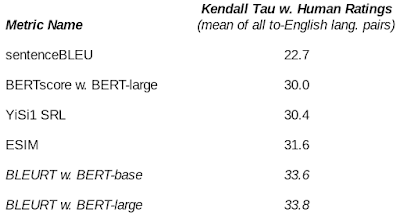

\
Article:https://ai.googleblog.com/2020/05/evaluating-natural-language-generation.html#:~:text=BLEURT%20is%20a%20novel,%20machine,ratings%20provided%20by%20the%20user \
GitHub: https://github.com/google-research/bleurt


In [82]:
import bleurt
from bleurt import checkpoint as checkpoint_lib
from bleurt import encoding
from bleurt import model
from bleurt.lib import experiment_utils
import tensorflow.compat.v1 as tf

In [73]:
def run_finetuning_pipeline(train_set, dev_set, run_in_lazy_mode=True):
  """Runs the full BLEURT fine-tuning pipeline."""

  if run_in_lazy_mode:
    tf.disable_eager_execution()

  bleurt_params = checkpoint_lib.get_bleurt_params_from_flags_or_ckpt()

  # Preprocessing and encoding for train and dev set.
  logging.info("*** Running pre-processing pipeline for training examples.")
  if FLAGS.serialized_train_set:
    train_tfrecord = FLAGS.serialized_train_set
  else:
    train_tfrecord = train_set + ".tfrecord"
  encoding.encode_and_serialize(
      train_set,
      train_tfrecord,
      vocab_file=bleurt_params["vocab_file"],
      do_lower_case=bleurt_params["do_lower_case"],
      sp_model=bleurt_params["sp_model"],
      max_seq_length=bleurt_params["max_seq_length"])

  logging.info("*** Running pre-processing pipeline for eval examples.")
  if FLAGS.serialized_dev_set:
    dev_tfrecord = FLAGS.serialized_dev_set
  else:
    dev_tfrecord = dev_set + ".tfrecord"
  encoding.encode_and_serialize(
      dev_set,
      dev_tfrecord,
      vocab_file=bleurt_params["vocab_file"],
      do_lower_case=bleurt_params["do_lower_case"],
      sp_model=bleurt_params["sp_model"],
      max_seq_length=bleurt_params["max_seq_length"])

  # Actual fine-tuning work.
  logging.info("*** Running fine-tuning.")
  train_eval_fun = experiment_utils.run_experiment
  model.run_finetuning(train_tfrecord, dev_tfrecord, train_eval_fun)

  # Deletes temp files.
  if not FLAGS.serialized_train_set:
    logging.info("Deleting serialized training examples.")
    tf.io.gfile.remove(train_tfrecord)
  if not FLAGS.serialized_dev_set:
    logging.info("Deleting serialized dev examples.")
    tf.io.gfile.remove(dev_tfrecord)

  # Gets export location.
  glob_pattern = os.path.join(FLAGS.model_dir, "export", "bleurt_best", "*")
  export_dirs = tf.io.gfile.glob(glob_pattern)
  assert export_dirs, "Model export directory not found."
  export_dir = export_dirs[0]

  # Finalizes the BLEURT checkpoint.
  logging.info("Exporting BLEURT checkpoint to {}.".format(export_dir))
  checkpoint_lib.finalize_bleurt_checkpoint(export_dir)

  return export_dir


In [74]:
run_finetuning_pipeline(train, dev)

INFO:tensorflow:Reading BLEURT parameters


UnrecognizedFlagError: Unknown command line flag 'f'

# Further Engineering

## Encoding

**Sklearn : BOW**\
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

**Sklearn : TF-IDF**\
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [106]:
# function for encoding the text
def encoding(train, dev, test, vectorizer):
    baseline_encoder = vectorizer()
    names = ['train', 'dev', 'test']
    for i,df in enumerate([train, dev, test]):
        for column in ['reference', 'translation']:
            encoded_df = names[i] + '_encoded_' + column
            if i == 0:
                vars()[encoded_df] = baseline_encoder.fit_transform(df[column]).todense()
            else:
                vars()[encoded_df] = baseline_encoder.transform(df[column]).todense()           
        y_name = 'y_' + names[i].split('_')[0]
        vars()[y_name] = np.array(df['avg-score'])
    return train_encoded_translation, train_encoded_reference, dev_encoded_reference,\
           dev_encoded_translation, test_encoded_translation, test_encoded_reference

# checking the sparsity of the encoded matrix
def get_sparsity(sparse_matrix):
    ''' Check for sparsity of the dataset'''
    matrix_size = sparse_matrix.shape[0]*sparse_matrix.shape[1] # Number of possible interactions in the matrix
    num_words = len(sparse_matrix.nonzero()[0]) # Number of words interacted with
    sparsity = 100*(1 - (num_words/matrix_size))
    return sparsity

In [ ]:
encoding(train, dev, test, TfidfVectorizer)
# encoding(train, dev, test, CountVectorizer)

In [44]:
get_sparsity(train_encoded_translation)

99.84900650211618

## Score Bins

In [59]:
def create_score_classes(df):
    score_classes = []
    for i in df['avg-score']:
        if i <= 20:
            score_classes.append(1)
        elif i <= 40:
            score_classes.append(2)
        elif i <= 60:
            score_classes.append(3)
        elif i <= 80:
            score_classes.append(4)
        else:
            score_classes.append(5)
    df['score_classes'] = score_classes
    return df.head()

In [60]:
create_score_classes(train)

reference  \
5954               i wa hoping to be in it until the end   
34334  the imam interviewed by kommersant who conduct...   
47395  fiji gave master class on the ownership of bal...   
20160    he did not violate his information duty he said   
18324  an investigation ha been opened which is a log...   

                                             translation   avg-score  \
5954   i had hoped to see it through to the end but t...   65.666667   
34334  the imam interviewed by kommersant who were co...   85.500000   
47395  fiji gave a masterclass in handling off loadin...  100.000000   
20160  according to the judgement the organiser had n...   77.000000   
18324  a criminal investigation ha been opened a logi...   79.000000   

       score_classes  
5954               4  
34334              5  
47395              5  
20160              4  
18324              4

In [61]:
create_score_classes(dev)

reference  \
62924  he carefully observed the action of his russia...   
47609  but it in my opinion somewhat tire with the su...   
77239                        there is an economic motive   
61084  it is understood that the first shipment of th...   
47115  the buyer of primark insulted the woman who sh...   

                                             translation  avg-score  \
62924  he carefully observed every word and action of...       11.0   
47609  but it is also what i find slightly exhausting...       73.0   
77239                   there is also an economic motive       93.0   
61084  it is understood that the first carriage of go...       69.0   
47115  primark shopper outraged at woman who brazenly...        6.0   

       score_classes  
62924              1  
47609              4  
77239              5  
61084              4  
47115              1

In [103]:
create_score_classes(test)

reference  \
36920  a such pita and discovers a female redhead gam...   
15960             de maizi re is also here to make sense   
51283  bodini said he hoped that the matter could be ...   
49847  bile spent the last three year dominated by it...   
73972  the moscow city tourist police unit commander ...   

                                             translation  avg-score  \
36920  it is in this state that he is found by the re...       40.0   
15960  de maizi re is also trying to strike a concili...       19.0   
51283  bordini said he waited for month for the situa...       97.0   
49847  bile ha spent the last three year dominating h...       98.0   
73972  lei sakov the brigade captain of moscow city p...       74.0   

       score_classes  
36920              2  
15960              1  
51283              5  
49847              5  
73972              4

# 5. Model <a class="anchor" id="5."></a>

### RNN

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [101]:
train.head()

reference  \
5954               i wa hoping to be in it until the end   
34334  the imam interviewed by kommersant who conduct...   
47395  fiji gave master class on the ownership of bal...   
20160    he did not violate his information duty he said   
18324  an investigation ha been opened which is a log...   

                                             translation   avg-score  \
5954   i had hoped to see it through to the end but t...   65.666667   
34334  the imam interviewed by kommersant who were co...   85.500000   
47395  fiji gave a masterclass in handling off loadin...  100.000000   
20160  according to the judgement the organiser had n...   77.000000   
18324  a criminal investigation ha been opened a logi...   79.000000   

       score_classes  
5954               4  
34334              5  
47395              5  
20160              4  
18324              4

In [102]:
train2 = train[['reference', 'translation', 'score_classes']]
train2.shape

(62150, 3)

In [94]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.

model.add(layers.Embedding(input_dim=1000, output_dim=64))


# model.add(Conv2D(32, (3,3), input_shape = (62150,3) , activation = 'relu'))
# # creating a Pooling layer: each window (pool) has size (2,2)
# model.add(MaxPooling2D(pool_size = (2,2)))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(5, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 163,461
Trainable params: 163,461
Non-trainable params: 0
_________________________________________________________________


In [95]:
# compiling the created model
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

### Evaluation 